In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

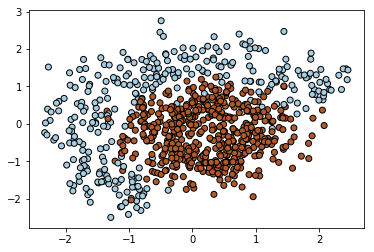

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
y = y.reshape((len(y), 1))
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X_ = tf.zeros((X.shape[0], 6))
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(X.shape[0], 1))], axis=1)
    return X_

def classify(X, w):
    X_tf = tf.placeholder(tf.float32, X.shape, "X")
    w_tf = tf.placeholder(tf.float32, w.shape, "w")
    X_ = expand(X_tf)
    ones = tf.ones((X.shape[0], 1))
    classifier = tf.where(tf.matmul(X_, w_tf) > 0, ones, -ones, name="classify")
    with tf.Session() as sess:
        return sess.run(classifier, feed_dict={X_tf: X, w_tf: w})

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_point_loss(X, y, w):
    return tf.maximum(tf.zeros((X.shape[0], 1)), 1 - y * tf.matmul(expand(X), w), name="loss")

def compute_loss(X, y, w):
    return tf.reduce_mean(compute_point_loss(X, y, w))
    
def compute_grad(X, y, w):
    loss = tf.squeeze(compute_point_loss(X, y, w))
    X_expand = expand(X)
    non_zero_grad_X = tf.where(loss > 0, X_expand * -y, tf.zeros(X_expand.shape), name="non_zero_grad")
    return tf.reshape(tf.reduce_sum(non_zero_grad_X, 0), w.shape) / X.shape[0].value
                                   
batch_size = 4
X_tf = tf.placeholder(tf.float32, shape=(batch_size, X.shape[1]), name="X")
X_tf_all = tf.placeholder(tf.float32, shape=X.shape, name="X")
y_tf = tf.placeholder(tf.float32, shape=(batch_size,1), name="y")
y_tf_all = tf.placeholder(tf.float32, shape=y.shape, name="y")
w_tf = tf.placeholder(tf.float32, shape=(6,1), name="w")


### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

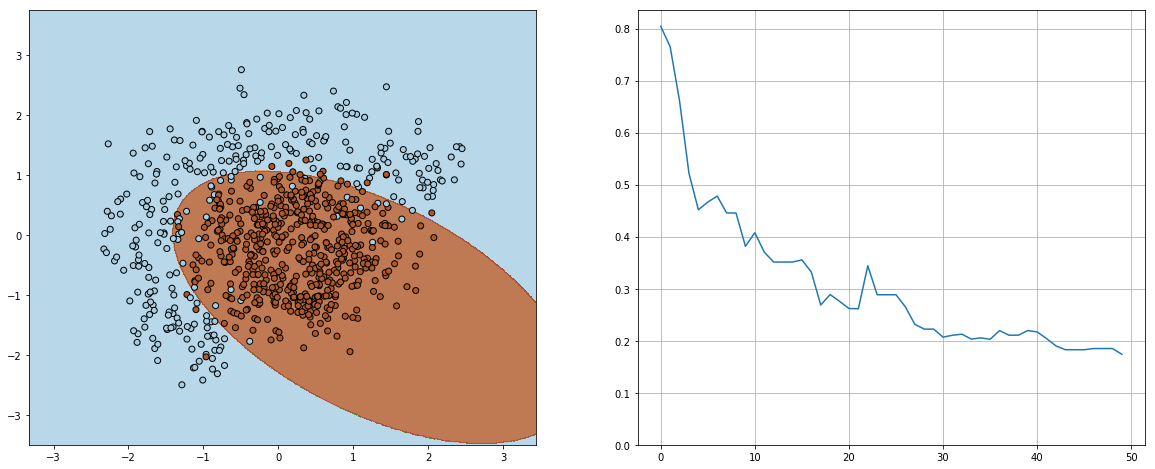

In [6]:
w = np.array([1,0,0,0,0,0], dtype=np.float32).reshape(6, 1)

alpha = 0.3 # learning rate

n_iter = 50
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        y_batch = y[ind, :]
        
        grad = sess.run(compute_grad(X_tf, y_tf, w_tf), feed_dict={X_tf: X_batch, y_tf: y_batch, w_tf: w})
        loss[i] = sess.run(compute_loss(X_tf_all, y_tf_all, w_tf), feed_dict={X_tf_all: X, y_tf_all: y, w_tf: w})
        #visualize(X_batch, y_batch, w, loss[i], n_iter)
        w = w - alpha * grad
    
visualize(X, y, w, loss, n_iter)
plt.clf()


Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

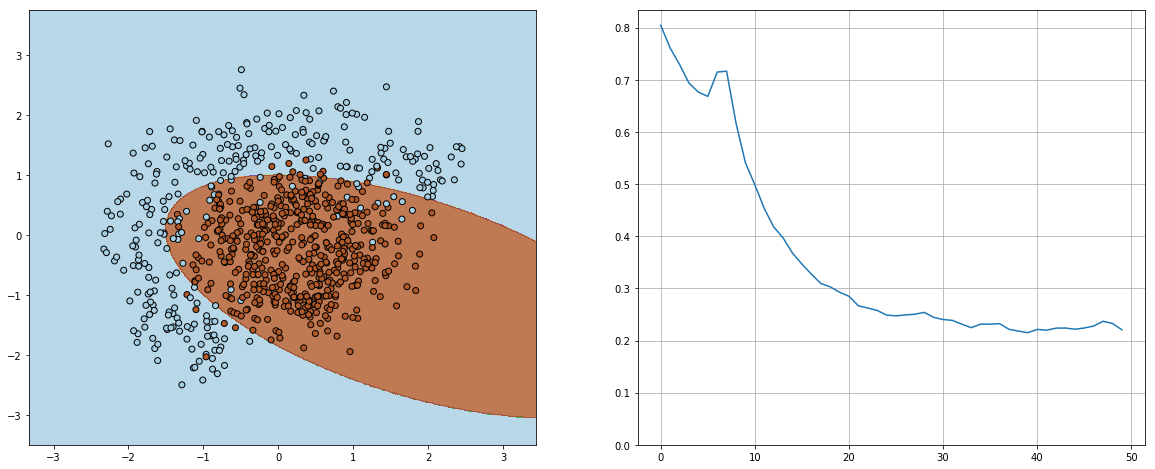

In [7]:
w = np.array([1,0,0,0,0,0], dtype=np.float32).reshape(6, 1)
v = np.zeros(w.shape, dtype=np.float32)

alpha = 0.1 # learning rate
mu = 0.5
n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        y_batch = y[ind, :]
        
        grad = sess.run(compute_grad(X_tf, y_tf, w_tf), feed_dict={X_tf: X_batch, y_tf: y_batch, w_tf: w})
        loss[i] = sess.run(compute_loss(X_tf_all, y_tf_all, w_tf), feed_dict={X_tf_all: X, y_tf_all: y, w_tf: w})
        #visualize(X_batch, y_batch, w, loss[i], n_iter)
        v = v * mu + alpha * grad
        w = w - v
    
visualize(X, y, w, loss, n_iter)
plt.clf()


Same task but for Nesterov's accelerated gradient:

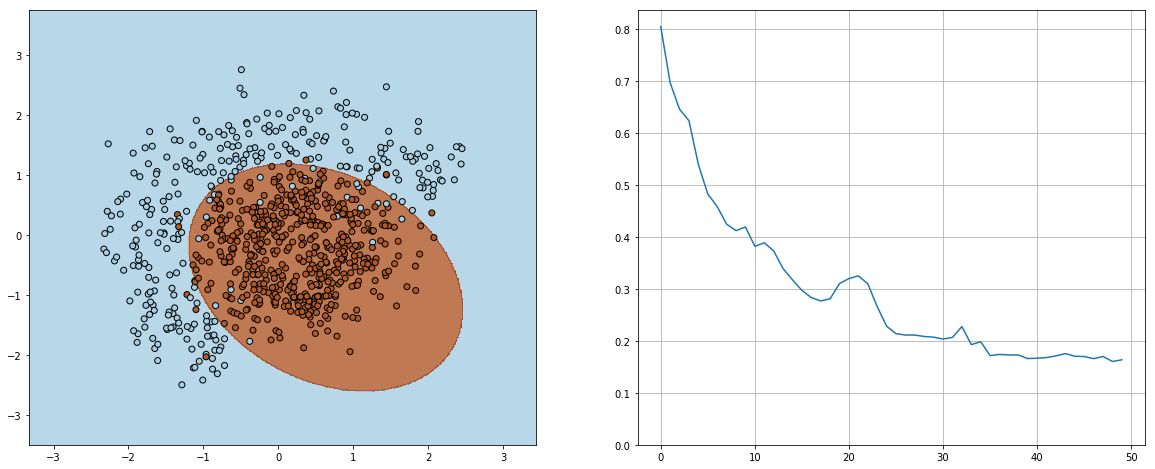

In [8]:
w = np.array([1,0,0,0,0,0], dtype=np.float32).reshape(6, 1)
v = np.zeros(w.shape, dtype=np.float32)

alpha = 0.1 # learning rate
mu = 0.5
n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        y_batch = y[ind, :]
        
        w = w - v
        grad = sess.run(compute_grad(X_tf, y_tf, w_tf), feed_dict={X_tf: X_batch, y_tf: y_batch, w_tf: w})
        loss[i] = sess.run(compute_loss(X_tf_all, y_tf_all, w_tf), feed_dict={X_tf_all: X, y_tf_all: y, w_tf: w})
        #visualize(X_batch, y_batch, w, loss[i], n_iter)
        v = v * mu + alpha * grad
        w = w - alpha * grad
    
visualize(X, y, w, loss, n_iter)
plt.clf()


Same task but for AdaGrad:

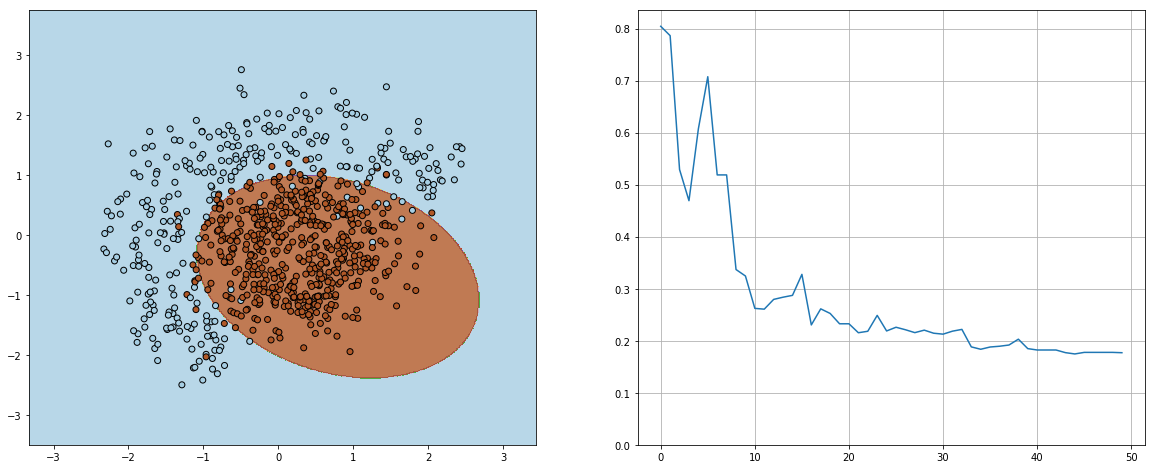

In [9]:
w = np.array([1,0,0,0,0,0], dtype=np.float32).reshape(6, 1)

alpha = 0.35 # learning rate
n_iter = 50
eps = 1e-8
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
c = np.zeros(w.shape, dtype=np.float32)

with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        y_batch = y[ind, :]
        
        grad = sess.run(compute_grad(X_tf, y_tf, w_tf), feed_dict={X_tf: X_batch, y_tf: y_batch, w_tf: w})
        c += grad ** 2
        loss[i] = sess.run(compute_loss(X_tf_all, y_tf_all, w_tf), feed_dict={X_tf_all: X, y_tf_all: y, w_tf: w})
        #visualize(X_batch, y_batch, w, loss[i], n_iter)
        w = w - alpha * grad / (eps + np.sqrt(c))
    
visualize(X, y, w, loss, n_iter)
plt.clf()


Same task but for AdaDelta:

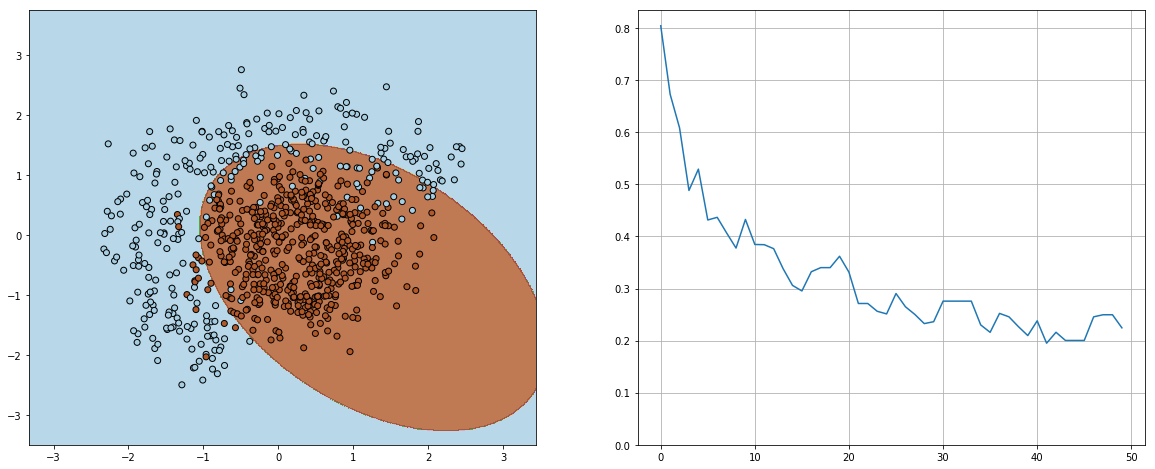

In [10]:
w = np.array([1,0,0,0,0,0], dtype=np.float32).reshape(6, 1)

alpha = 0.1 # learning rate
beta = 0.8
n_iter = 50
eps = 1e-8
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
c = np.zeros(w.shape, dtype=np.float32)

with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        y_batch = y[ind, :]
        
        grad = sess.run(compute_grad(X_tf, y_tf, w_tf), feed_dict={X_tf: X_batch, y_tf: y_batch, w_tf: w})
        c = c * beta + (1 - beta) * grad**2
        loss[i] = sess.run(compute_loss(X_tf_all, y_tf_all, w_tf), feed_dict={X_tf_all: X, y_tf_all: y, w_tf: w})
        #visualize(X_batch, y_batch, w, loss[i], n_iter)
        w = w - alpha * grad / (eps + np.sqrt(c))
    
visualize(X, y, w, loss, n_iter)
plt.clf()


Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

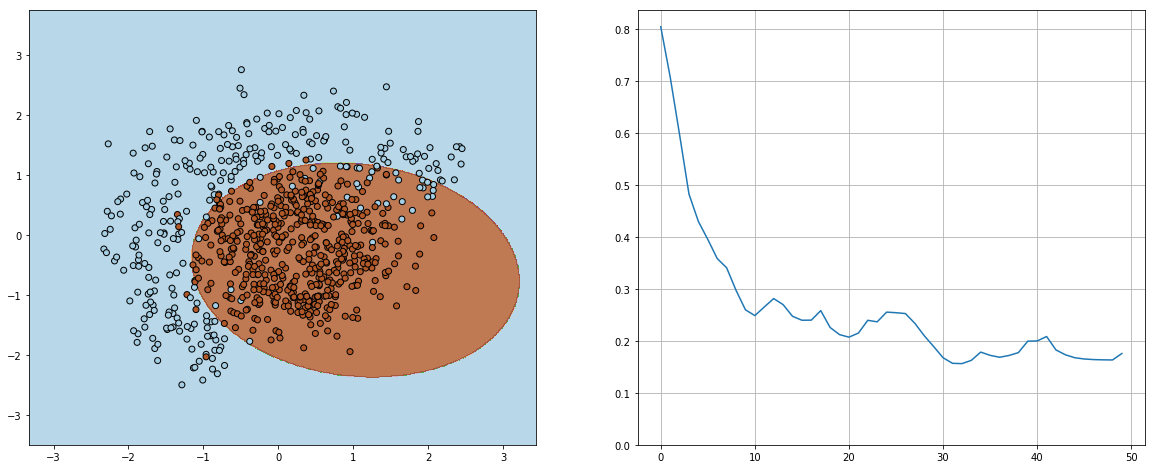

In [11]:
w = np.array([1,0,0,0,0,0], dtype=np.float32).reshape(6, 1)
v = np.zeros(w.shape, dtype=np.float32)

alpha = 0.2 # learning rate
mu = 0.7
beta = 0.8
n_iter = 50
eps = 1e-8
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
c = np.zeros(w.shape, dtype=np.float32)

with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        X_batch = X[ind, :]
        y_batch = y[ind, :]
        
        grad = sess.run(compute_grad(X_tf, y_tf, w_tf), feed_dict={X_tf: X_batch, y_tf: y_batch, w_tf: w})
        v = v * mu + (1 - mu) * grad
        c = c * beta + (1 - beta) * grad**2
        loss[i] = sess.run(compute_loss(X_tf_all, y_tf_all, w_tf), feed_dict={X_tf_all: X, y_tf_all: y, w_tf: w})
        #visualize(X_batch, y_batch, w, loss[i], n_iter)
        w = w - alpha * v / (eps + np.sqrt(c))
    
visualize(X, y, w, loss, n_iter)
plt.clf()
